In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 8
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [7]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [8]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [18]:
par,loss=inference.fit(epochs=100,batch_size=batch_size,data_loader=train_data,verbose=True)

  1%|          | 1/100 [00:14<24:05, 14.60s/it]

loss: 1.0498


 11%|█         | 11/100 [01:41<12:55,  8.71s/it]

loss: 0.4135


 21%|██        | 21/100 [03:16<12:37,  9.58s/it]

loss: 0.3813


 31%|███       | 31/100 [04:56<11:12,  9.75s/it]

loss: 0.3667


 41%|████      | 41/100 [06:27<08:52,  9.03s/it]

loss: 0.3576


 51%|█████     | 51/100 [07:54<07:00,  8.58s/it]

loss: 0.3514


 61%|██████    | 61/100 [09:23<05:41,  8.76s/it]

loss: 0.3467


 71%|███████   | 71/100 [10:52<04:15,  8.81s/it]

loss: 0.3428


 81%|████████  | 81/100 [12:26<02:50,  8.97s/it]

loss: 0.3400


 91%|█████████ | 91/100 [14:00<01:28,  9.83s/it]

loss: 0.3373


100%|██████████| 100/100 [15:26<00:00,  9.27s/it]


In [19]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

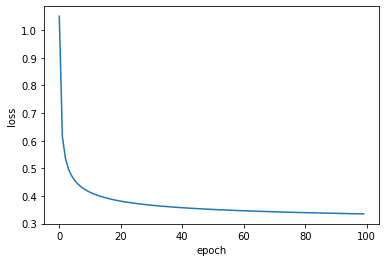

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [22]:
model.net.save_parameters('softmax_sgd_100_epochs.params')

In [9]:
model.net.load_parameters('softmax_sgd_100_epochs.params',ctx=model_ctx)
par=dict()
for name,gluon_par in model.net.collect_params().items():
    par.update({name:gluon_par.data()})
               

In [10]:
total_samples,total_labels=inference.predict(par,batch_size=batch_size,num_samples=10,data_loader=val_data)

In [11]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       979
           1       0.97      0.97      0.97      1133
           2       0.92      0.88      0.90      1030
           3       0.90      0.89      0.89      1008
           4       0.88      0.91      0.90       980
           5       0.84      0.84      0.84       890
           6       0.88      0.94      0.91       956
           7       0.91      0.93      0.92      1027
           8       0.84      0.85      0.85       973
           9       0.93      0.85      0.89      1008

    accuracy                           0.90      9984
   macro avg       0.90      0.90      0.90      9984
weighted avg       0.90      0.90      0.90      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [26]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [27]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [28]:
par,loss,posterior_samples=inference.fit(epochs=10,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

 10%|█         | 1/10 [00:08<01:19,  8.86s/it]

epsilon: 0.0002
loss: 0.8457


 20%|██        | 2/10 [00:18<01:12,  9.10s/it]

epsilon: 0.0002
loss: 0.7189


 30%|███       | 3/10 [00:27<01:03,  9.04s/it]

epsilon: 0.0001
loss: 0.6912


 40%|████      | 4/10 [00:35<00:53,  8.98s/it]

epsilon: 0.0001
loss: 0.6666


 50%|█████     | 5/10 [00:44<00:44,  8.94s/it]

epsilon: 0.0001
loss: 0.6556


 60%|██████    | 6/10 [00:54<00:37,  9.32s/it]

epsilon: 0.0001
loss: 0.6419


 70%|███████   | 7/10 [01:03<00:27,  9.11s/it]

epsilon: 0.0001
loss: 0.6320


 80%|████████  | 8/10 [01:13<00:18,  9.22s/it]

epsilon: 0.0001
loss: 0.6300


 90%|█████████ | 9/10 [01:22<00:09,  9.16s/it]

epsilon: 0.0001
loss: 0.6238


100%|██████████| 10/10 [01:30<00:00,  9.07s/it]

epsilon: 0.0001
loss: 0.6141


In [ ]:
loss,posterior_samples=inference.sample(epochs=100,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

  1%|          | 1/100 [00:08<14:42,  8.91s/it]

epsilon: 0.0002
loss: 0.7941


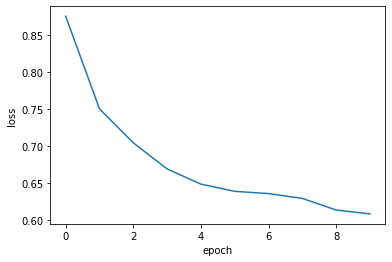

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [22]:
total_samples,total_labels=inference.predict(posterior_samples,5,data_loader=val_data)

In [24]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.1,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       980
           1       0.86      0.98      0.92      1135
           2       0.71      0.86      0.77      1032
           3       0.73      0.83      0.77      1010
           4       0.68      0.89      0.77       982
           5       0.72      0.62      0.67       892
           6       0.85      0.75      0.80       958
           7       0.76      0.80      0.78      1028
           8       0.65      0.49      0.56       974
           9       0.97      0.47      0.63      1009

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.76     10000
weighted avg       0.78      0.77      0.76     10000



# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [68]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [69]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=bbb(model,model.par,step_size=0.05,ctx=model_ctx)

In [70]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

<module 'hamiltonian.inference.bbb' from '../hamiltonian/inference/bbb.py'>

In [71]:
par,loss,(means,sigmas)=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 10/10 [07:41<00:00, 46.12s/it]


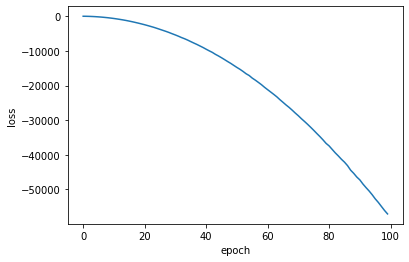

In [66]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [67]:
from sklearn.metrics import classification_report
import mxnet.gluon.probability as mxp

def softplus(x):
    return nd.log(1. + nd.exp(x))

posterior=dict()
for var in par.keys():
    variational_posterior=mxp.normal.Normal(loc=means[var],
                                            scale=softplus(sigmas[var]))
    posterior.update({var:variational_posterior})
    
samples=[]
for _ in range(100):
    post_par=dict()
    for var in par.keys():
        post_par.update({var:posterior[var].sample().as_nd_ndarray()})
    y_pred=model.predict(post_par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1425
           1       0.00      0.00      0.00      1564
           2       0.00      0.00      0.00      1438
           3       0.00      0.00      0.00      1442
           4       0.00      0.00      0.00      1366
           5       0.00      0.00      0.00      1244
           6       0.10      0.83      0.18      1363
           7       0.21      0.35      0.26      1429
           8       0.04      0.01      0.01      1342
           9       0.00      0.00      0.00      1387

    accuracy                           0.12     14000
   macro avg       0.03      0.12      0.05     14000
weighted avg       0.03      0.12      0.05     14000



# Posterior Diagnostics <a class="anchor" id="chapter4"></a>

In [36]:
import arviz as az

In [39]:
np.expand_dims(np.asarray([posterior_samples['0.bias'][0].asnumpy() for sample in posterior_samples['0.bias']]),0).shape

(1, 30, 10)

In [40]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [58]:
posterior_samples_numpy['0-weights'].shape

(1, 5, 784, 10)

In [59]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [60]:
ess=az.ess(dataset)

In [61]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 4.0 4.0 ... 4.0 4.0
    bias           (bias_dim_0) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0

In [62]:
az.summary(dataset)

arviz - WARNING - Shape validation failed: input_shape: (1, 5), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"weights[0,0]",1.862,0.0,1.862,1.862,0.0,0.0,4.0,4.0,NaN
"weights[0,1]",-2.258,0.0,-2.258,-2.258,0.0,0.0,4.0,4.0,NaN
"weights[0,2]",-1.389,0.0,-1.389,-1.389,0.0,0.0,4.0,4.0,NaN
"weights[0,3]",-1.668,0.0,-1.668,-1.668,0.0,0.0,4.0,4.0,NaN
"weights[0,4]",-1.602,0.0,-1.602,-1.602,0.0,0.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...
bias[5],0.509,0.0,0.509,0.509,0.0,0.0,4.0,4.0,NaN
bias[6],-0.058,0.0,-0.058,-0.058,0.0,0.0,4.0,4.0,NaN
bias[7],0.362,0.0,0.362,0.362,0.0,0.0,4.0,4.0,NaN
bias[8],-0.409,0.0,-0.409,-0.409,0.0,0.0,4.0,4.0,NaN


In [63]:
784*10+10

7850